In [1]:
import os
import sys
import shutil
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import os
import cv2
import random

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), ##resize 
    transforms.ToTensor() ##transform to tensor
])
train_dataset = ImageFolder(root='./ArchiTective- Architectural Style Image Classification Model.v6i.folder/train', transform=transform)
loaded_train = DataLoader(train_dataset, batch_size=128, shuffle=True) 

In [4]:
print(train_dataset.classes)

['Art Nouveau', 'Baroque', 'Beaux-Arts', 'Byzantine', 'Deconstructivism', 'Gothic', 'Palladian', 'Postmodern', 'Romanesque']


Text(0.5, 1.0, 'Byzantine')

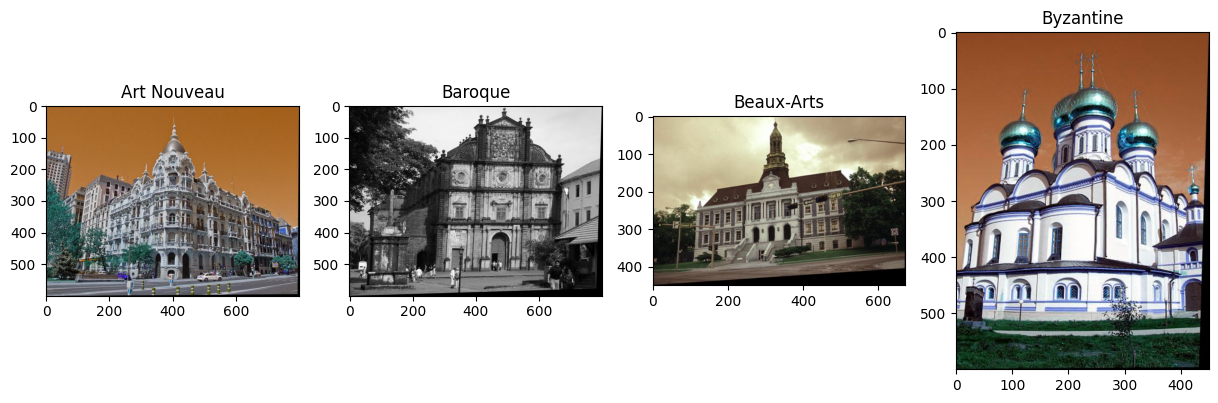

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes = axes.flatten()
img1 = cv2.imread('ArchiTective- Architectural Style Image Classification Model.v6i.folder/train/Art Nouveau/1830_800px-Casa_Gallardo_-_03_jpg.rf.de4a4666b1da47a23f41cb8c6c39631f.jpg')
axes[0].imshow(img1)
axes[0].set_title('Art Nouveau')
img2 = cv2.imread('ArchiTective- Architectural Style Image Classification Model.v6i.folder/train/Baroque/127_800px-Goa_Velha_Basilica_Bom_Jesus_jpg.rf.4e8fdbfb8d6fc34d7a60e9f7bd50f93c.jpg')
axes[1].imshow(img2)
axes[1].set_title('Baroque')
img3 = cv2.imread('ArchiTective- Architectural Style Image Classification Model.v6i.folder/train/Beaux-Arts/1160_Hall_County_Courthouse-2C_Grand_Island_jpg.rf.a8d63bb3ab61b3769c85a424d0849e61.jpg')
axes[2].imshow(img3)
axes[2].set_title('Beaux-Arts')
img4 = cv2.imread('ArchiTective- Architectural Style Image Classification Model.v6i.folder/train/Byzantine/1667_450px-Valdaysky_Monastery_30_jpg.rf.6f3ae555e659d8cecff80b972a3a550c.jpg')
axes[3].imshow(img4)
axes[3].set_title('Byzantine')

In [7]:
import torch.nn.functional as F

In [8]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


###GOAL IS TO ARRIVE AT ISOTROPIC GAUSSIAN DISTRIBUTION, WITH MEAN (MU) 0 AND VARIANCE (SIGMA) FIXED IN ALL DIRECTIONS
##Else Sampling will not work
def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

In [9]:
# Define beta schedule
T = 300  ##timesteps
betas = linear_beta_schedule(timesteps=T)   ##can use cosine here rather than linear increase

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)  ###alpha dash
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [97]:
print(betas[0:10])

tensor([1.0000e-04, 1.6656e-04, 2.3311e-04, 2.9967e-04, 3.6622e-04, 4.3278e-04,
        4.9933e-04, 5.6589e-04, 6.3244e-04, 6.9900e-04])


In [98]:
print(alphas[0:10])

tensor([0.9999, 0.9998, 0.9998, 0.9997, 0.9996, 0.9996, 0.9995, 0.9994, 0.9994,
        0.9993])


In [10]:
type(train_dataset)

torchvision.datasets.folder.ImageFolder

In [10]:
def load_transformed_dataset():
    data_transform = transforms.Compose([
    transforms.Resize((224, 224)), ##resize 
    transforms.ToTensor(), ##transform to tensor
    transforms.RandomHorizontalFlip(),
    transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
])
    train_dataset = ImageFolder(root='./ArchiTective- Architectural Style Image Classification Model.v6i.folder/train', transform=data_transform)
    test_dataset = ImageFolder(root='./ArchiTective- Architectural Style Image Classification Model.v6i.folder/test', transform=data_transform)

    #train = torchvision.datasets.StanfordCars(root=".", download=True, 
    #                                     transform=data_transform)

    #test = torchvision.datasets.StanfordCars(root=".", download=True, 
    #                                     transform=data_transform, split='test')
    return torch.utils.data.ConcatDataset([train_dataset, test_dataset])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=128, shuffle=True, drop_last=True)

In [119]:
len(train_dataset)

3728

In [40]:
data_images = []
data_labels = []

for i in range(0, 100):
    img, label = train_dataset[i]
    data_images.append(img.permute(1, 2, 0))
    data_labels.append(label)

images = torch.stack(data_images)
labels = torch.tensor(data_labels)

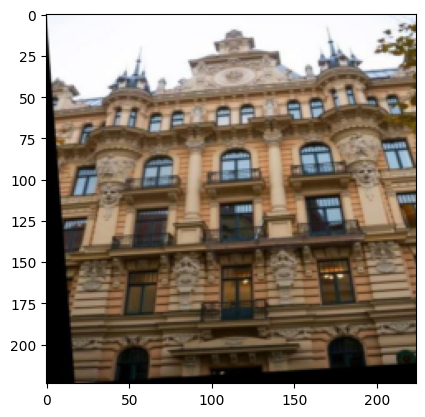

In [41]:
plt.imshow(data_images[12])

In [ ]:
# Create a TensorDataset
subset_dataset = TensorDataset(images, labels)

# Create a DataLoader
subset_dataloader = DataLoader(subset_dataset, batch_size=128, shuffle=True)

In [21]:
data_images[0].shape

torch.Size([224, 224, 3])

In [12]:
dataloader_2 = DataLoader(images, batch_size=128, shuffle=True, drop_last=True)

In [35]:
type(dataloader)

torch.utils.data.dataloader.DataLoader

In [53]:
#type(data)
first_image, first_label = data[0]
first_image.shape

torch.Size([3, 224, 224])

In [50]:
img_1, lbl_1 = train_dataset[100]
img_1.shape

torch.Size([3, 224, 224])

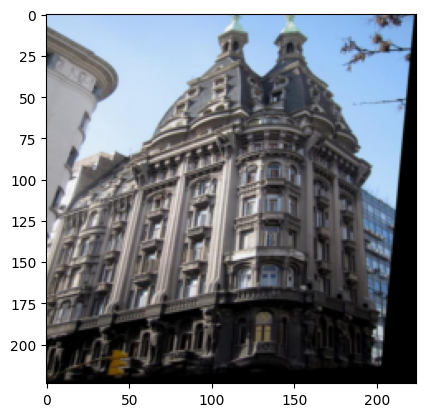

In [51]:
plt.imshow(img_1.permute(1, 2, 0))
plt.show()

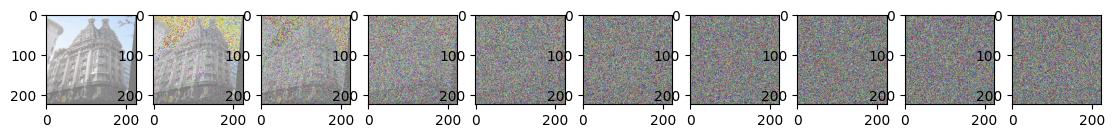

In [52]:
# Simulate forward diffusion
image = img_1.permute(1, 2, 0) #next(iter(dataloader))[0]

#from PIL import Image

#image_path = 'ArchiTective- Architectural Style Image Classification Model.v6i.folder/train/Art Nouveau/1830_800px-Casa_Gallardo_-_03_jpg.rf.de4a4666b1da47a23f41cb8c6c39631f.jpg'
#image = Image.open(image_path)

# Apply the same transformations as in the dataset
#transform = transforms.Compose([
#    transforms.Resize((224, 224)),
#    transforms.ToTensor()
#])
#image = transform(image).unsqueeze(0)  # Add batch dimension

plt.figure(figsize=(15,15))
#plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(img_1, t)
    show_tensor_image(img)

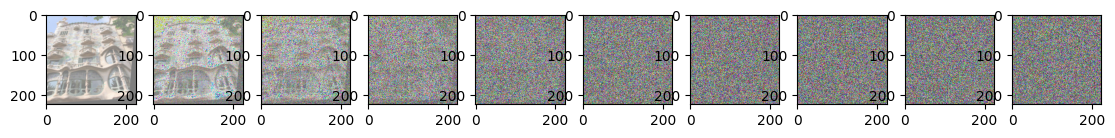

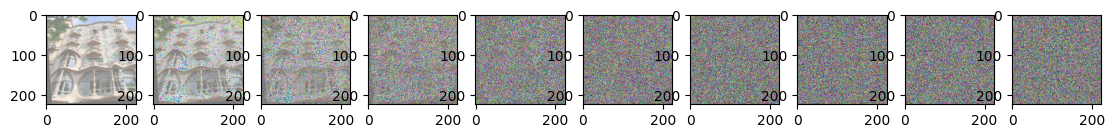

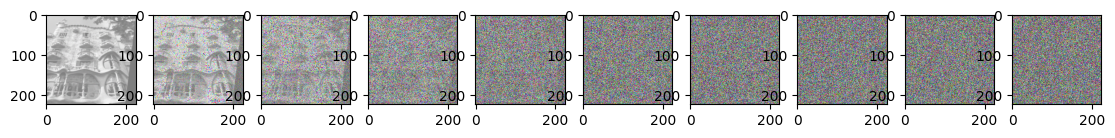

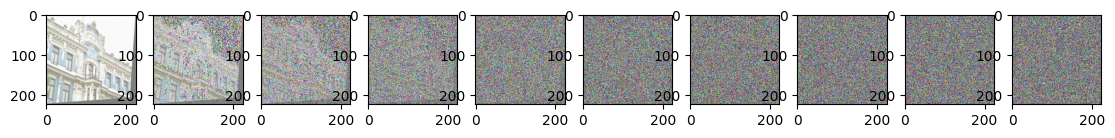

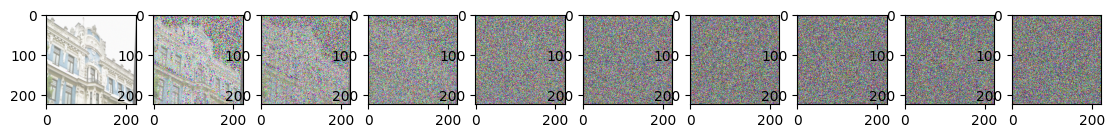

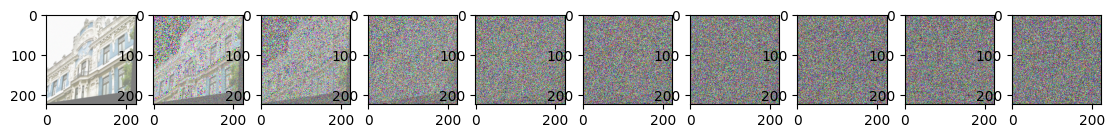

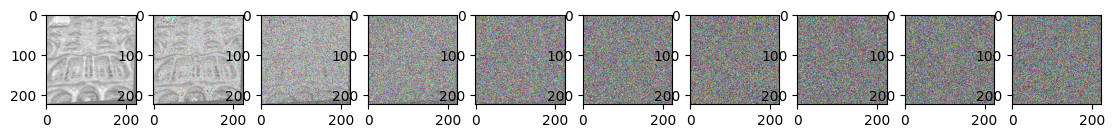

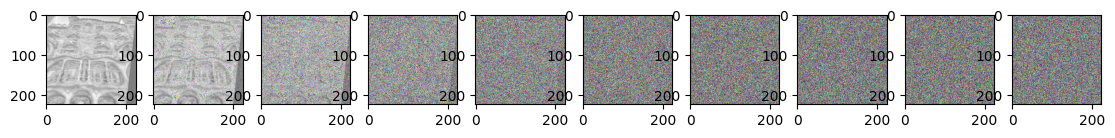

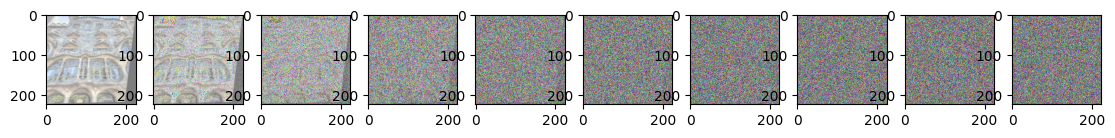

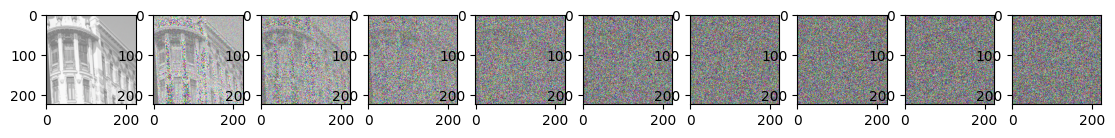

In [56]:
for i in range(10):
    img_1, lbl_1 = train_dataset[i]
    image = img_1.permute(1, 2, 0)
    plt.figure(figsize=(15,15))
    #plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for idx in range(0, T, stepsize):
        t = torch.Tensor([idx]).type(torch.int64)
        plt.subplot(1, num_images + 1, int(idx / stepsize) + 1)
        img, noise = forward_diffusion_sample(img_1, t)
        show_tensor_image(img)
    
    plt.show()

In [15]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

In [16]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [26]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = (224, 224, 3)
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    #plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

In [39]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 10 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(subset_dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (128,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      #if epoch % 5 == 0 and step == 0:
      print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
      sample_plot_image()

RuntimeError: The size of tensor a (128) must match the size of tensor b (2) at non-singleton dimension 0